<a href="https://colab.research.google.com/github/sepidehrezvani/10-/blob/main/simulation_of_article_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

In [2]:
# پارامترهای شبکه
num_bs = 3                 # تعداد ایستگاه‌های پایه
num_users = 60             # تعداد کاربران
num_slices = 3             # eMBB, URLLC, mMTC
bandwidth_total = 100.0    # MHz
power_total = 40.0         # Watt

# ویژگی‌های کاربر: [SNR(dB), طلب نرخ, کلاس اسلایس, تاخیر هدف]
snr_db = np.random.uniform(0, 25, size=(num_users, 1))
rate_demand = np.random.uniform(1, 10, size=(num_users, 1))        # Mbps
slice_class = np.random.choice([0,1,2], size=(num_users, 1))       # 0:eMBB, 1:URLLC, 2:mMTC
delay_target = np.where(slice_class==1, 5, np.where(slice_class==2, 100, 50))  # ms

features = np.hstack([snr_db, rate_demand, slice_class, delay_target]).astype(np.float32)

# نگاشت کاربران به BS (نزدیک‌ترین)
bs_positions = np.array([[0,0],[500,0],[250,400]], dtype=np.float32)
user_positions = np.random.uniform([0,0],[500,400], size=(num_users,2)).astype(np.float32)
assign_bs = np.argmin(
    np.linalg.norm(user_positions[:,None,:] - bs_positions[None,:,:], axis=2),
    axis=1
)

# تابع نرخ تقریبی با شانون (باند × log2(1+SNR))
def snr_linear(snr_db):
    return 10**(snr_db/10)

def rate_mbps(bw_mhz, snr_db):
    snr = snr_linear(snr_db)
    return bw_mhz * np.log2(1 + snr)

# ظرفیت هر BS (پهنای‌باند و توان اولیه)
bw_bs = np.array([bandwidth_total/num_bs]*num_bs, dtype=np.float32)
pw_bs = np.array([power_total/num_bs]*num_bs, dtype=np.float32)

In [3]:
# سهم اولیه اسلایس‌ها (نرمال‌شده به 1)
slice_shares = np.array([0.5, 0.2, 0.3], dtype=np.float32)   # eMBB, URLLC, mMTC

def adjust_slice_shares(rate_gap, delay_violations, prev_shares, lr=0.05):
    # rate_gap: کمبود میانگین نرخ برای eMBB
    # delay_violations: درصد نقض تاخیر برای URLLC
    delta = np.array([rate_gap, delay_violations, -(rate_gap+delay_violations)/2], dtype=np.float32)
    new_shares = prev_shares + lr * delta
    new_shares = np.clip(new_shares, 0.05, 0.9)
    new_shares = new_shares / new_shares.sum()
    return new_shares

In [4]:
def allocate_bs_resources(bw_bs, pw_bs, slice_shares):
    # پهنای‌باند و توان هر اسلایس در هر BS
    bw_slice_bs = bw_bs[:,None] * slice_shares[None,:]
    pw_slice_bs = pw_bs[:,None] * slice_shares[None,:]
    return bw_slice_bs, pw_slice_bs

def per_user_allocation(features, assign_bs, bw_slice_bs, pw_slice_bs):
    # تقسیم منابع اسلایس بین کاربران همان اسلایس در هر BS به نسبت نیاز یا وزن
    num_bs = bw_slice_bs.shape[0]
    num_slices = bw_slice_bs.shape[1]
    bw_user = np.zeros((features.shape[0],), dtype=np.float32)
    pw_user = np.zeros((features.shape[0],), dtype=np.float32)

    for b in range(num_bs):
        idx_b = np.where(assign_bs == b)[0]
        if len(idx_b) == 0: continue

        for s in range(num_slices):
            idx_s = idx_b[np.where(features[idx_b,2].astype(int) == s)[0]]
            if len(idx_s) == 0: continue

            # وزن‌ها: eMBB بر اساس نرخ‌نیاز، URLLC بر اساس تاخیر هدف، mMTC وزن برابر
            if s == 0:   # eMBB
                weights = features[idx_s,1] + 1e-3
            elif s == 1: # URLLC
                weights = 1.0 / (features[idx_s,3] + 1e-3)
            else:        # mMTC
                weights = np.ones(len(idx_s), dtype=np.float32)

            weights = weights / weights.sum()
            bw_share = bw_slice_bs[b, s]
            pw_share = pw_slice_bs[b, s]

            bw_user[idx_s] = bw_share * weights
            pw_user[idx_s] = pw_share * weights

    return bw_user, pw_user

def compute_kpis(features, bw_user):
    # نرخ تقریبی هر کاربر
    rates = rate_mbps(bw_user, features[:,0].squeeze())
    # KPI اسلایس‌ها
    e_idx = np.where(features[:,2]==0)[0]
    u_idx = np.where(features[:,2]==1)[0]
    m_idx = np.where(features[:,2]==2)[0]
    e_rate_mean = rates[e_idx].mean() if len(e_idx)>0 else 0.0

    # نقض تاخیر URLLC: اگر نرخ کمتر از آستانه نسبت به تاخیر هدف باشد (ساده‌سازی)
    u_rate = rates[u_idx] if len(u_idx)>0 else np.array([])
    u_delay = features[u_idx,3].squeeze() if len(u_idx)>0 else np.array([])
    # معیار ساده: اگر نرخ < 0.2*delay_target → نقض
    violations = (u_rate < 0.2*u_delay).mean() if len(u_idx)>0 else 0.0

    m_rate_mean = rates[m_idx].mean() if len(m_idx)>0 else 0.0
    sum_rate = rates.sum()
    return {
        "e_rate_mean": float(e_rate_mean),
        "u_delay_viol": float(violations),
        "m_rate_mean": float(m_rate_mean),
        "sum_rate": float(sum_rate),
        "rates": rates
    }

In [5]:
rounds = 20
log_e_rate = []
log_u_viol = []
log_m_rate = []
log_sum_rate = []
log_shares = []

for r in range(rounds):
    # ترافیک پویا: تغییرات کوچک در نیازها و تاخیر هدف
    features[:,1] *= np.random.uniform(0.95, 1.05, size=(num_users,))   # نرخ‌نیاز
    features[:,3] *= np.random.uniform(0.95, 1.05, size=(num_users,))   # تاخیر هدف

    # مرحله اسلایسینگ
    bw_slice_bs, pw_slice_bs = allocate_bs_resources(bw_bs, pw_bs, slice_shares)

    # تخصیص کاربر
    bw_user, pw_user = per_user_allocation(features, assign_bs, bw_slice_bs, pw_slice_bs)

    # KPIها
    kpis = compute_kpis(features, bw_user)

    # تطبیق سهم اسلایس‌ها
    slice_shares = adjust_slice_shares(rate_gap=max(0.0, 6.0 - kpis["e_rate_mean"]),
                                       delay_violations=kpis["u_delay_viol"],
                                       prev_shares=slice_shares, lr=0.1)

    # لاگ
    log_e_rate.append(kpis["e_rate_mean"])
    log_u_viol.append(kpis["u_delay_viol"])
    log_m_rate.append(kpis["m_rate_mean"])
    log_sum_rate.append(kpis["sum_rate"])
    log_shares.append(slice_shares.copy())

    print(f"Round {r+1:02d} | eMBB mean {kpis['e_rate_mean']:.2f} Mbps | URLLC viol {kpis['u_delay_viol']:.2f} | mMTC mean {kpis['m_rate_mean']:.2f} | Sum {kpis['sum_rate']:.2f} | Shares {slice_shares}")

log_shares = np.array(log_shares)

Round 01 | eMBB mean 7.46 Mbps | URLLC viol 0.17 | mMTC mean 6.24 | Sum 392.17 | Shares [0.4958677  0.21487601 0.2892562 ]
Round 02 | eMBB mean 7.41 Mbps | URLLC viol 0.11 | mMTC mean 6.02 | Sum 394.54 | Shares [0.49312818 0.22473861 0.28213325]
Round 03 | eMBB mean 7.37 Mbps | URLLC viol 0.11 | mMTC mean 5.87 | Sum 394.97 | Shares [0.49040368 0.23454666 0.2750496 ]
Round 04 | eMBB mean 7.36 Mbps | URLLC viol 0.06 | mMTC mean 5.72 | Sum 396.73 | Shares [0.48904526 0.23943713 0.2715176 ]
Round 05 | eMBB mean 7.37 Mbps | URLLC viol 0.06 | mMTC mean 5.65 | Sum 397.18 | Shares [0.48769054 0.24431403 0.2679954 ]
Round 06 | eMBB mean 7.34 Mbps | URLLC viol 0.06 | mMTC mean 5.57 | Sum 397.63 | Shares [0.48633957 0.24917741 0.26448292]
Round 07 | eMBB mean 7.31 Mbps | URLLC viol 0.06 | mMTC mean 5.50 | Sum 398.00 | Shares [0.4849924  0.25402737 0.26098022]
Round 08 | eMBB mean 7.28 Mbps | URLLC viol 0.06 | mMTC mean 5.43 | Sum 397.89 | Shares [0.48364893 0.25886387 0.25748718]
Round 09 | eMBB 

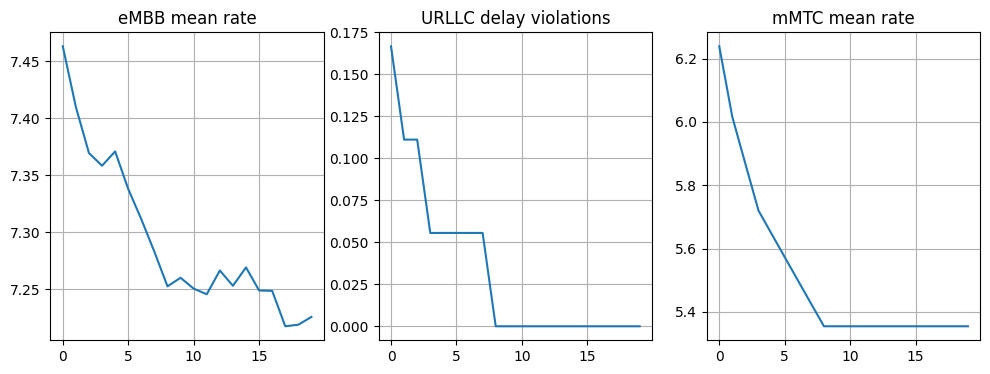

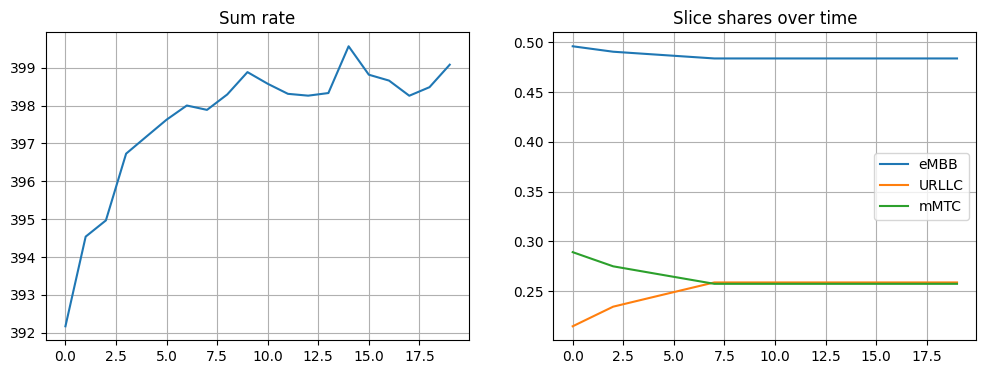

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.plot(log_e_rate); plt.title("eMBB mean rate"); plt.grid(True)
plt.subplot(1,3,2); plt.plot(log_u_viol); plt.title("URLLC delay violations"); plt.grid(True)
plt.subplot(1,3,3); plt.plot(log_m_rate); plt.title("mMTC mean rate"); plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(log_sum_rate); plt.title("Sum rate"); plt.grid(True)
plt.subplot(1,2,2);
plt.plot(log_shares[:,0], label='eMBB');
plt.plot(log_shares[:,1], label='URLLC');
plt.plot(log_shares[:,2], label='mMTC');
plt.title("Slice shares over time"); plt.legend(); plt.grid(True)
plt.show()

Saved README.md and figures. Ready for GitHub upload.


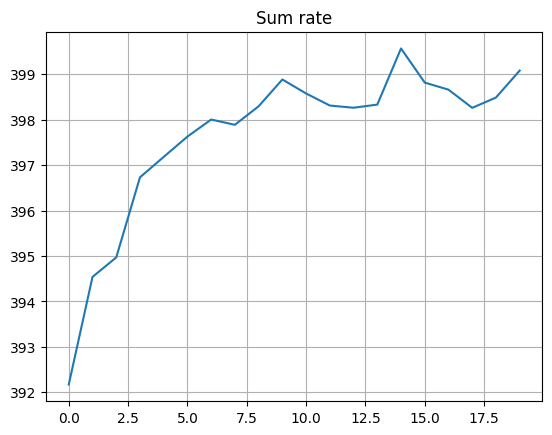

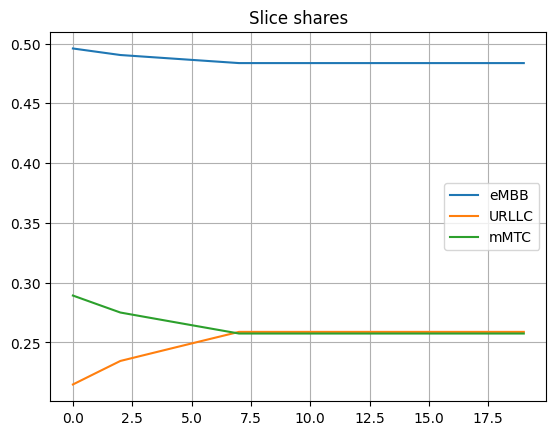

In [7]:
# ذخیره نوت‌بوک: از منو File → Download .ipynb
# ذخیره نمودارها
plt.figure(); plt.plot(log_sum_rate); plt.title("Sum rate"); plt.grid(True); plt.savefig("sum_rate.png")
plt.figure(); plt.plot(log_shares[:,0], label='eMBB'); plt.plot(log_shares[:,1], label='URLLC'); plt.plot(log_shares[:,2], label='mMTC'); plt.legend(); plt.title("Slice shares"); plt.grid(True); plt.savefig("slice_shares.png")

# ایجاد README محلی برای آپلود در GitHub (اختیاری)
readme = """# AI-Driven 5G Network Optimization: Resource Allocation, Traffic Management, and Dynamic Slicing

- **Resource Allocation:** Per-BS and per-user allocation driven by slice-aware weights.
- **Traffic Management:** Dynamic demands and latency targets per round.
- **Dynamic Slicing:** Adaptive slice shares (eMBB/URLLC/mMTC) updated by KPI feedback.

## How to run in Colab
1) Run cells in order.
2) Inspect KPI logs per round.
3) Export notebook and upload to GitHub.

## Outputs
- sum_rate.png
- slice_shares.png
"""
with open("README.md","w") as f:
    f.write(readme)
print("Saved README.md and figures. Ready for GitHub upload.")